## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# additional packages
import re
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
congress_tweets = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
#congress_tweets = congress_tweets.sample(...)
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.081010e+18,RepByrne,2019-01-03T21:23:00-05:00,Great news for Baldwin County! The economy of ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
1,1.080880e+18,RepByrne,2019-01-03T12:30:38-05:00,Outstanding news today from @Airbus! @JetBlue ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
2,1.080830e+18,RepByrne,2019-01-03T09:12:07-05:00,RT @senatemajldr Democrats will have to get se...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
3,1.080890e+18,RepByrne,2019-01-03T13:20:53-05:00,Here is a sign of things to come: As Democrats...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
4,1.080870e+18,RepByrne,2019-01-03T12:10:26-05:00,Let's understand what we're dealing with here:...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [4]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)
    
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    punc = set(punctuation)
    text = remove_emojis(text)
    # Keep @ Symbol to Remove Handles
    punc.remove('@')

    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]

    # Remove \n
    spacy_words = [word for word in spacy_words if not word.startswith('\n')]

    # Remove QT
    spacy_words = [word for word in spacy_words if not word.startswith('QT')]

    # Remove RT
    spacy_words = [word for word in spacy_words if not word.startswith('RT')]

    # Remove Handles
    spacy_words = [word for word in spacy_words if not word.startswith('@')]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1

In [6]:
# Sample 1% randomly from the entire set of tweets
congress_tweets_sample = congress_tweets.sample(frac=0.01)
congress_tweets_sample['tokens'] = congress_tweets_sample['text'].map(lambda x: rem_punc_stop(x))

In [7]:
congress_tweets_sample.loc[(congress_tweets_sample['name_wikipedia']=='Bernie Sanders') | (congress_tweets_sample['name_wikipedia']=='Angus King'), "party"] = "Democrat"

In [8]:
congress_tweets_sample_eda = congress_tweets_sample[(congress_tweets_sample['party']=='Democrat') | (congress_tweets_sample['party'] == 'Republican')]

In [69]:
congress_tweets_sample_eda['tweet_length'] = congress_tweets_sample_eda['text'].apply(len)

In [70]:
congress_tweets_sample_eda['word_count'] = congress_tweets_sample_eda['text'].apply(lambda x: len(str(x).split()))

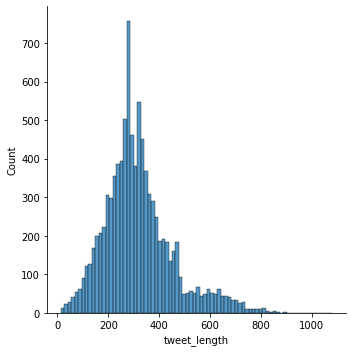

In [71]:
sns.displot(congress_tweets_sample_eda, x="tweet_length")
plt.show()

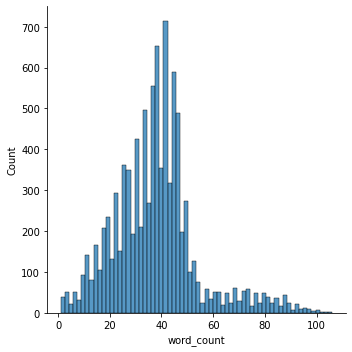

In [72]:
sns.displot(congress_tweets_sample_eda, x="word_count")
plt.show()

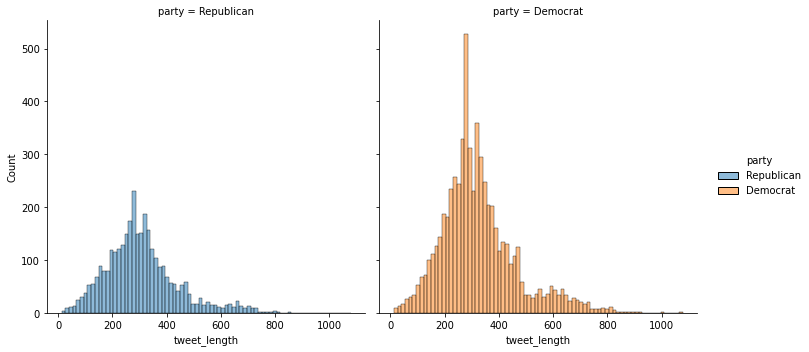

In [73]:
sns.displot(congress_tweets_sample_eda, x="tweet_length", hue = "party", col = "party")
plt.show()

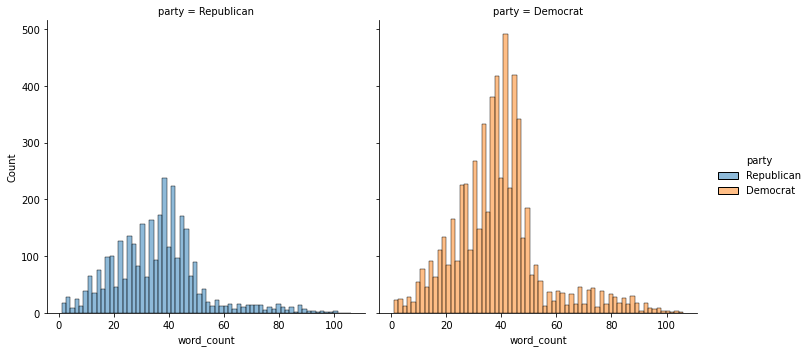

In [74]:
sns.displot(congress_tweets_sample_eda, x="word_count", hue = "party", col = "party")
plt.show()

Here, we can see that the shape of the distribution for tweet length does not differ between Democrats and Republicans. This is the same case for word count. However, the biggest difference is the overall count differences: Republicans tweet less than Democrats.

### EDA 2

In [75]:
congress_tweets_sample_senator = congress_tweets_sample[(congress_tweets_sample['position']=='Sen')]
congress_tweets_sample_rep = congress_tweets_sample[(congress_tweets_sample['position']=='Rep')]

In [ ]:
congress_tweets_sample_senator['tokens'] = congress_tweets_sample_senator['text'].map(lambda x: rem_punc_stop(x))
congress_tweets_sample_senator['tokens'] = congress_tweets_sample_senator['tokens'].map(lambda text: ' '.join(text))

In [77]:
congress_tweets_sample_rep['tokens'] = congress_tweets_sample_rep['text'].map(lambda x: rem_punc_stop(x))
congress_tweets_sample_rep['tokens'] = congress_tweets_sample_rep['tokens'].map(lambda text: ' '.join(text))

<ipython-input-77-d63c55344d39>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  congress_tweets_sample_rep['tokens'] = congress_tweets_sample_rep['text'].map(lambda x: rem_punc_stop(x))
<ipython-input-77-d63c55344d39>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  congress_tweets_sample_rep['tokens'] = congress_tweets_sample_rep['tokens'].map(lambda text: ' '.join(text))


920736    Thanks 1 million Americans     receiving bonus...
641943    Ohio 4 confirmed cases CODVID19 Here suggestio...
412311    suspend executions BidenHarris administration ...
394841    Congratulations Chief Tom Levy securing federa...
55121     However entire process played public view year...
                                ...                        
273314    A complete total waste time His reckless behav...
248303    Over 2 months ago George Floyd JusticeinPolici...
237448    Children opportunity education learn grow Hono...
814472    BREAKING If vote Texas vote mail IF YOU APPLY ...
515421    SocialSecurity threat insolvency constant repu...
Name: tokens, Length: 7266, dtype: object

Topic Model Outcome for Senators

In [78]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [79]:
X = congress_tweets_sample_senator['tokens']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)
tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()
lda = LatentDirichletAllocation(n_components=5, max_iter=20, random_state=0)
lda = lda.fit(numpy.array(dense_matrix))

tf_feature_names = tf.get_feature_names_out()
print_top_words(lda, tf_feature_names, 20)

topic_dist = lda.transform(tfidf_matrix)
topic_dist_df = pd.DataFrame(topic_dist).reset_index(drop = True)

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Topic #0:
amp today health president    trump new — time climate live care americans covid19 tune great senate people need help

Topic #1:
amp — trump health senate    today protect coronavirus bipartisan covid19 new national president state american ” people day country

Topic #2:
amp act families    trump senate need work help bill working care today people president women bipartisan states ” support

Topic #3:
amp “    ” need senate today veterans help time president trump democrats people covid19 vote health state impeachment year

Topic #4:
amp today senate people care new support health help covid19 — federal need americans    country state passed washington american



There are many reoccurring terms in each topic (e.g., the first four mention the President and Trump; the first, second, and fifth mention americans). This may siggest that senators tend to pay a lot of attention on the President, Trump, Americans, COVID19, health, and help. 

Topic Model Outcome for Representatives

In [80]:
X = congress_tweets_sample_rep['tokens']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)
tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()
lda = LatentDirichletAllocation(n_components=5, max_iter=20, random_state=0)
lda = lda.fit(numpy.array(dense_matrix))

tf_feature_names = tf.get_feature_names_out()
print_top_words(lda, tf_feature_names, 20)

topic_dist = lda.transform(tfidf_matrix)
topic_dist_df = pd.DataFrame(topic_dist).reset_index(drop = True)

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



Topic #0:
116th authorization enter casework photo hesitate grocery custody al03 diplomatic kong hong va10 luncheon dealing scenes bloomberg appreciated mom usa

Topic #1:
de internet christmas telephone el hall scams pt schiff en pm tune town babies ginsburg joining la transcript quo ct

Topic #2:
amp    today people house president need trump covid19 thank act health work help time congress americans day american support

Topic #3:
de tobacco y en recreation la los points coffee bureau el que para lung inthistogetherohio northam oc trail resignation gdp

Topic #4:
2020census count counted fill happy celebrating census maternal easter joy census2020 justiceinpolicing passover tells person giuliani hanukkah citizen celebrate happiness



Representatives, on the other hand, have much more diversity amongst them, which is not surprising given there's many more of them. The third topic is the closest to mirroring that of Senators, but the other four topics have mixed results.

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [81]:
# Use all of these legislators' tweets
congress_tweets_sentiment = congress_tweets[(congress_tweets['name_wikipedia']=='Alexandria Ocasio-Cortez') | (congress_tweets['name_wikipedia'] == 'Marco Rubio')]

In [84]:
len(congress_tweets_sentiment)

5106

In [85]:
congress_tweets_sentiment['tokens'] = congress_tweets_sentiment['text'].map(lambda x: rem_punc_stop(x))

<ipython-input-85-399d3ae6c2fa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  congress_tweets_sentiment['tokens'] = congress_tweets_sentiment['text'].map(lambda x: rem_punc_stop(x))


In [86]:
congress_tweets_sentiment['tokens'] = congress_tweets_sentiment['tokens'].map(lambda text: ' '.join(text))
congress_tweets_sentiment['polarity'] = congress_tweets_sentiment['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
congress_tweets_sentiment['subjectivity'] = congress_tweets_sentiment['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

<ipython-input-86-3d664a1b9b54>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  congress_tweets_sentiment['tokens'] = congress_tweets_sentiment['tokens'].map(lambda text: ' '.join(text))
<ipython-input-86-3d664a1b9b54>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  congress_tweets_sentiment['polarity'] = congress_tweets_sentiment['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
<ipython-input-86-3d664a1b9b54>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [87]:
dummy_variable_names = pd.get_dummies(congress_tweets_sentiment['name_wikipedia'])

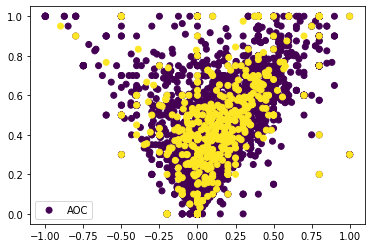

In [88]:
plt.scatter(x=congress_tweets_sentiment['polarity'], y=congress_tweets_sentiment['subjectivity'], c=dummy_variable_names['Alexandria Ocasio-Cortez'], cmap = "viridis")
plt.legend(["AOC" , "Marco Rubio"])
plt.show()

The x-axis represents polarity scores, while the y-axis represents subjectivity. A higher polarity score suggests that there is positive sentiment, a negative score suggests that there is negative sentiment, and a score of 0 suggests there is neutral sentiment. The range is from -1 to 1 for polarity. A higher subjectivity score suggests that there is more personal opinion than factual information, while a lower score suggests the opposite. The range is 0 to 1 for subjectivity. AOC and Marco Rubio have very similar polarity versus subjectivity scores, which suggests they share a similar amount of positive/negative/neutral sentiments and personal opinion/factual information. However, AOC does appear to have more dots spread out than Rubio.

Democrats vs. Republicans

In [9]:
#congress_tweets_sentiment_party = congress_tweets_sample[(congress_tweets_sample['party']=='Democrat') | (congress_tweets_sample['party'] == 'Republican')]
congress_tweets_sample['tokens_joined'] = congress_tweets_sample['tokens'].map(lambda text: ' '.join(text))
congress_tweets_sample['polarity'] = congress_tweets_sample['tokens_joined'].map(lambda text: TextBlob(text).sentiment.polarity)
congress_tweets_sample['subjectivity'] = congress_tweets_sample['tokens_joined'].map(lambda text: TextBlob(text).sentiment.subjectivity)

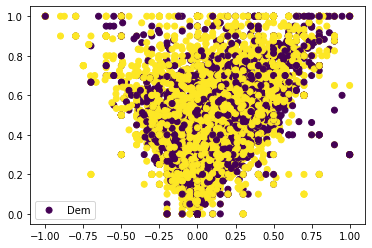

In [92]:
dummy_variable_names = pd.get_dummies(congress_tweets_sample['party'])
plt.scatter(x=congress_tweets_sample['polarity'], y=congress_tweets_sample['subjectivity'], c=dummy_variable_names['Democrat'], cmap = "viridis")
plt.legend(["Dem" , "Rep"])
plt.show()

Senators vs. Representatives

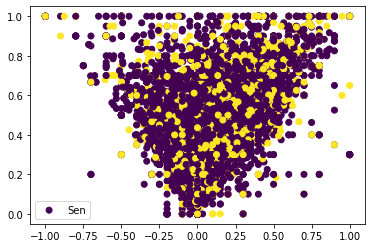

In [93]:
dummy_variable_names = pd.get_dummies(congress_tweets_sample['position'])
plt.scatter(x=congress_tweets_sample['polarity'], y=congress_tweets_sample['subjectivity'], c=dummy_variable_names['Sen'], cmap = "viridis")
plt.legend(["Sen" , "Rep"])
plt.show()

Between Republicans and Democrats, as well as Senators and House of Representatives, the tweets all have similar polarity versus subjectivity scores. Rarely do either groups have highly sentimental (polarity of +1 or -1) tweets that also happen to be highly factual (subjectivity of 0).

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [10]:
congress_tweets_sample['token_len'] = congress_tweets_sample['tokens'].apply(len)
congress_tweets_sample['token_len']

487006    13
343978    14
678607    29
859914    24
257163    26
          ..
892026    20
93476     27
123415    17
455707    11
567574    22
Name: token_len, Length: 9468, dtype: int64

In [11]:
congress_tweets_sample['word_count'] = congress_tweets_sample['tokens'].apply(lambda x: len(str(x).split()))
congress_tweets_sample['word_count']

487006    17
343978    16
678607    30
859914    24
257163    26
          ..
892026    20
93476     27
123415    17
455707    11
567574    22
Name: word_count, Length: 9468, dtype: int64

In [12]:
# Engineered Features
engineered_features = congress_tweets_sample[['token_len', 'word_count', 'polarity', 'subjectivity']].reset_index(drop = True)

### Bag-of-words or Tf-idf

In [ ]:
# Frequency Based featurization
X = congress_tweets_sample['tokens_joined']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)
tfidf_matrix =  tf.fit_transform(X)

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [100]:
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names_out()).reset_index(drop = True)

### Word Embedding

In [101]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Colab Notebooks/GoogleNews-vectors-negative300 (1).bin.gz', binary = True) 

In [102]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in word2vec_model.vocab]
    return numpy.mean(word2vec_model[doc], axis=0)

In [103]:
# embedding based featurization
empty_list_embeddings_means = []
index_list = []
for index, doc in enumerate(congress_tweets_sample['tokens']):
  doc = [word for word in doc if word in model.vocab]
  if len(doc) == 0:
    index_list.append(index)
    continue
  empty_list_embeddings_means.append(numpy.mean(model[doc], axis=0))
    
doc_average_embeddings = numpy.array(empty_list_embeddings_means) # list to array

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

In [ ]:
# Model One: Engineered Feautures Only for Democrat vs. Republican
# Model Two: TF-IDF Only for Democrat vs. Republican
# Model Three: Average Word Embeddings Only for Democrat vs. Republican

# Model Four: Engineered Feautures Only for Senator vs. Representative
# Model Five: TF-IDF Only for Senator vs. Representative
# Model Six: Average Word Embeddings Only for Senator vs. Representative

# Accuracy Metrics for all 6 Models

# Model Seven: Best Model Technique from 1-6 Only Non-Text Features
# Model Eight: Best Model from 1-6 with Text and Non-Text Features

# Accuracy Metrics for last 2 models

In [ ]:
congress_tweets_sample = congress_tweets_sample.reset_index(drop = True).drop(index =index_list, axis = 0)

### Train Six Models with Just Text

In [ ]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])
lb_style = LabelBinarizer()

#Models 1 and 2
dataframes = [engineered_features, tfidf_df]
featurization_technique = ['Engineered Text Features', 'Tf-idf Features']
y = congress_tweets_sample['party_binary'] = lb_style.fit_transform(congress_tweets_sample['party'])

for dataframe, featurization in zip(dataframes, featurization_technique):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    logit_reg = LogisticRegression()
    logit_model = logit_reg.fit(X_train, y_train.ravel())
    y_pred = logit_model.predict(X_test)
    print(featurization_technique)
    print("Accuracy Score:", accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall', recall_score(y_test, y_pred))
    print('F1 Score', f1_score(y_test, y_pred))
    print(" ")

['Engineered Text Features', 'Tf-idf Features']
Accuracy Score: 0.6520591341077085
Precision: 0.0
Recall 0.0
F1 Score 0.0
 


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Model 3 
dataframes2 = [doc_average_embeddings]
featurization_technique_2 = ['Word2Vec Features']
y = congress_tweets_sentiment_word2vec_model_data['party'] = lb_style.fit_transform(congress_tweets_sentiment_word2vec_model_data['party'])

In [ ]:
# Models 4 and 5

# Model 6

### Two Combined Models

In [ ]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
...

My models above could not be run in Colab because the site keeps on crashing.

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Preprocessing techniques need to be customized to account for text-specific considerations that may make it difficult to classify outcomes or determine relevant statistics. In my approach, for example, I removed the symbol that represented quoted tweets (QT) and retweets (RT), as well as username handles. These characters do not represent meaningful information and can cloud sentiments or other important characteristics that represent the information being analyzed.**

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**I found evidence that suggested Democrats and Republicans do NOT have different sentiments in their tweets. The same conclusion holds between Senators and Representatives.**

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**Validating with a supervised learning algorithm is valuable because it ensures that we do not overfit our data with our models.**

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**The intution behind combining text and non-text feature is to ensure if other variables in the dataset are more influential in determining our outcome variables of interest. Perhaps, e.g., the gender of the individual influenced, alongside their tweets, whether our model could predict their chances of being determined either category.**